In [579]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing and analysis // read csv
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import datasets
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-power-forecasting/Turbine_Data.csv


# Step 1: Define the problem

We have data of a windmill and the aim is to predict the wind power that could be generated from the windmill for the next 15 days. A long term wind forecasting technique is thus required.

# Step 2: Gather the data

Import [Wind Power Forecasting](https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting) data into notebook and then read the csv.

In [594]:
#import data from file
X = pd.read_csv('../input/wind-power-forecasting/Turbine_Data.csv')

#a dataset should be broken into 3 splits: train, test, and (final) validation
X.tail()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468
118223,2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,0.0,58.581716,54.080505,...,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,G01,203.0,3.475205


# Step 3: Prepare the data

## Explore features

In [581]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    118224 non-null  object 
 1   ActivePower                   94750 non-null   float64
 2   AmbientTemperatue             93817 non-null   float64
 3   BearingShaftTemperature       62518 non-null   float64
 4   Blade1PitchAngle              41996 non-null   float64
 5   Blade2PitchAngle              41891 non-null   float64
 6   Blade3PitchAngle              41891 non-null   float64
 7   ControlBoxTemperature         62160 non-null   float64
 8   GearboxBearingTemperature     62540 non-null   float64
 9   GearboxOilTemperature         62438 non-null   float64
 10  GeneratorRPM                  62295 non-null   float64
 11  GeneratorWinding1Temperature  62427 non-null   float64
 12  GeneratorWinding2Temperature  62449 non-null

* *Time Stamp*: Should make this the index and also create a 'Time'-Variable.
* *ActivePower*: The power generated from the turbine. Dependent variable (target). 20 % missing values.
* *AmbientTemperatue*: Within the temperature range from -20 degrees to 50 degrees, the wind turbine should operate regularly. At higher temperatures the air density will be low, which could lessen the energy output. If the temperature is too low, the blades and other parts might be frozen, and the wind turbine will stop working. | Notice the typo in the column name, that should be corrected! 21 % missing values.
* ...
* *WTG*: Turbine name. Can be dropped!
* *WindDirection*: This could be important. 39 % missing values.
* *WindSpeed*: Wind speed (in km/h) should be a very important factor! If the wind speed is higher, the rotor speed will become faster, so the output energy will be increased. On the contrary, when wind speed is lower, the rotor will become slower. 20 % missing values.

(22 columns)

## Correcting aberrant values and outliers

In [582]:
# Rename 'AmbientTemperatue' to 'AmbientTemperature'
X.rename(columns = {'AmbientTemperatue':'AmbientTemperature'}, inplace = True)

In [583]:
# Drop WTG
X = X.drop(['WTG'], axis=1)

In [584]:
# How many missing values?
missing_values_count = X.isnull().sum()
print(missing_values_count)
print("-"*10)

# how many total missing values do we have?
total_cells = np.product(X.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print('Percent of data that is missing:\n', percent_missing)

Unnamed: 0                          0
ActivePower                     23474
AmbientTemperature              24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WindDirection                   45946
WindSpeed                       23629
dtype: int64
----------
Percent of data that is missing:
 41.46531362578866


41 % of the data is missing, which is a lot! Figure out why the data is missing! It probably wasn't recorded, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's.

In [585]:
# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
# X.fillna(method='bfill', axis=0).fillna(0)

# remove all the rows that contain a missing value
X = X.dropna()
X.info()

# What about SimpleImputer?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32728 entries, 70789 to 118223
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    32728 non-null  object 
 1   ActivePower                   32728 non-null  float64
 2   AmbientTemperature            32728 non-null  float64
 3   BearingShaftTemperature       32728 non-null  float64
 4   Blade1PitchAngle              32728 non-null  float64
 5   Blade2PitchAngle              32728 non-null  float64
 6   Blade3PitchAngle              32728 non-null  float64
 7   ControlBoxTemperature         32728 non-null  float64
 8   GearboxBearingTemperature     32728 non-null  float64
 9   GearboxOilTemperature         32728 non-null  float64
 10  GeneratorRPM                  32728 non-null  float64
 11  GeneratorWinding1Temperature  32728 non-null  float64
 12  GeneratorWinding2Temperature  32728 non-null  float64
 

In [586]:
# How many missing values now?
missing_values_count = X.isnull().sum()
print(missing_values_count)
print("-"*10)

# how many total missing values do we have?
total_cells = np.product(X.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print('Percent of data that is missing:\n', percent_missing)

Unnamed: 0                      0
ActivePower                     0
AmbientTemperature              0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
ControlBoxTemperature           0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64
----------
Percent of data that is missing:
 0.0


## Creating new features for analysis

In [587]:
# Time dummy
X['Time-step'] = np.arange(len(X.index))

X = X.drop('Unnamed: 0', axis=1)
# Parsing dates
#X['Date'] = pd.to_datetime(X['Unnamed: 0'].str.split(pat=' ', expand=True)[0])
#X['Time'] = pd.to_datetime(X['Unnamed: 0'].str.split(pat=' ', expand=True)[1])
#X = X.drop('Unnamed: 0', axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32728 entries, 70789 to 118223
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ActivePower                   32728 non-null  float64
 1   AmbientTemperature            32728 non-null  float64
 2   BearingShaftTemperature       32728 non-null  float64
 3   Blade1PitchAngle              32728 non-null  float64
 4   Blade2PitchAngle              32728 non-null  float64
 5   Blade3PitchAngle              32728 non-null  float64
 6   ControlBoxTemperature         32728 non-null  float64
 7   GearboxBearingTemperature     32728 non-null  float64
 8   GearboxOilTemperature         32728 non-null  float64
 9   GeneratorRPM                  32728 non-null  float64
 10  GeneratorWinding1Temperature  32728 non-null  float64
 11  GeneratorWinding2Temperature  32728 non-null  float64
 12  HubTemperature                32728 non-null  float64
 

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

No categorial features to encode!

## Converting fields to the correct format for calculations and presentation

We'll be working with the first column from the dataframe. Let's make sure it actually looks like it contains dates.


# Step 4: Split Training and Test Data


In [588]:
# Make target variable
y = X['ActivePower']
X = X.drop(['ActivePower'], axis=1)

# Split Training and Test Data
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

# Step 5: Train a Model

In [589]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
model_fit = xgbr.fit(xtrain, ytrain)

In [590]:
# After training the model, we'll check the model training score
score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

Training score:  0.9998667918619336


# Step 6: Cross-Validation

In [591]:
# We can also apply the cross-validation method to evaluate the training score
scores = cross_val_score(xgbr, xtrain, ytrain, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 1.00


In [592]:
# Next, we can predict test data, then check the prediction accuracy. Here, we'll use MSE and RMSE as accuracy metrics.
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 157.87
RMSE: 12.56


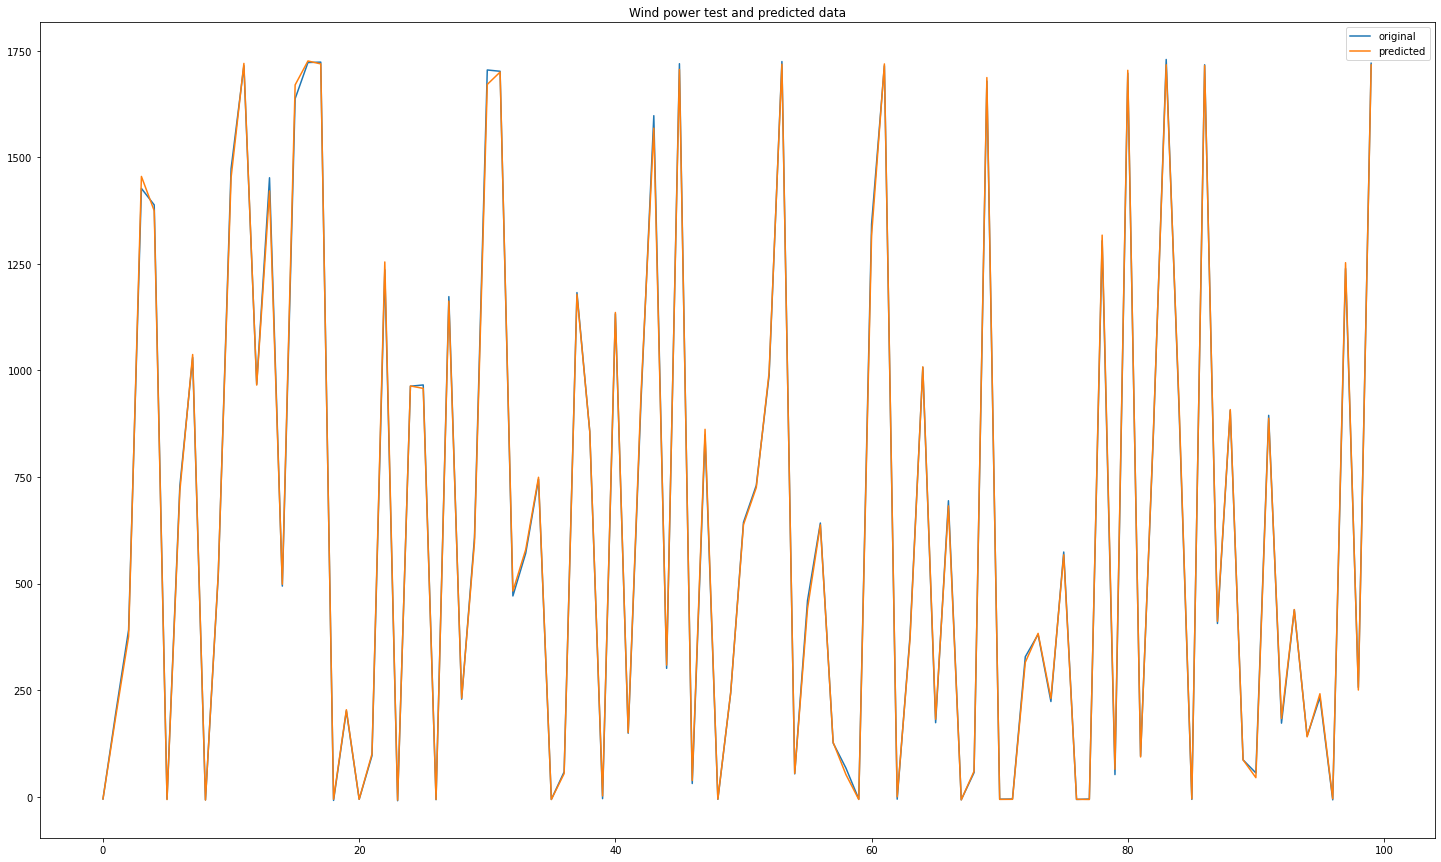

In [593]:
# Finally, we'll visualize the original and predicted test data in a plot to compare visually.
x_ax = range(len(ytest))
plt.figure(figsize=(25,15))
plt.plot(x_ax[:100], ytest[:100], label="original")
plt.plot(x_ax[:100], ypred[:100], label="predicted")

plt.title("Wind power test and predicted data")

plt.legend()
plt.show()